In [32]:
import tensorflow as tf
from tqdm import tqdm
import copy
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [33]:
clients = [0 , 1, 2, 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19]
epochs = 20

In [34]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train_all = x_train_all.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [35]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))


# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


# Define the MAML model
class MAML(tf.keras.Model):
    def __init__(self, model):
        super(MAML, self).__init__()
        self.model = model

    def train_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            loss = self.compiled_loss(y, y_pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        y_pred = self.model(x)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Define the meta-learning parameters
num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

In [36]:
from sklearn.model_selection import train_test_split

# assume X is your feature data and y is your target data
X_train, X_test, y_train, y_test = train_test_split(
    x_train_all, y_train_all, test_size=0.2, random_state=42
)

# split data into n parts
n_parts = len(clients)
part_size = len(X_train) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = X_train[start:end]
    y_part = y_train[start:end]
    dataset_parts.append((X_part, y_part))

In [37]:
def model_init():
    model = MAML(create_model())
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model

In [38]:
models = []
for _ in range(len(clients)):
    models.append(model_init())

In [39]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel() 
ckks_params = {
    "scheme": "CKKS", 
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [40]:
shapedims = [l.shape for l in models[0].get_weights()]
print(shapedims)

[(3, 3, 1, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (576, 64), (64,), (64, 10), (10,)]


In [41]:
def encrypt_wt(wtarray):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    return cwt
        

In [42]:
def aggregate_wt(cwts):
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res
    

In [43]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, models):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [44]:
accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

In [45]:
# def create_model():
#     model = tf.keras.models.Sequential(
#         [
#             tf.keras.layers.Conv2D(
#                 32, (3, 3), activation="relu", input_shape=(28, 28, 1)
#             ),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
#             tf.keras.layers.MaxPooling2D((2, 2)),
#             tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(64, activation="relu"),
#             tf.keras.layers.Dense(10),
#         ]
#     )
#     return model

313/313 [==============================] - 1s 2ms/step - loss: 0.1778 - accuracy: 0.9456
Epoch 1/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1144 - accuracy: 0.9500
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9700
Epoch 3/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0331 - accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0112 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 8ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================

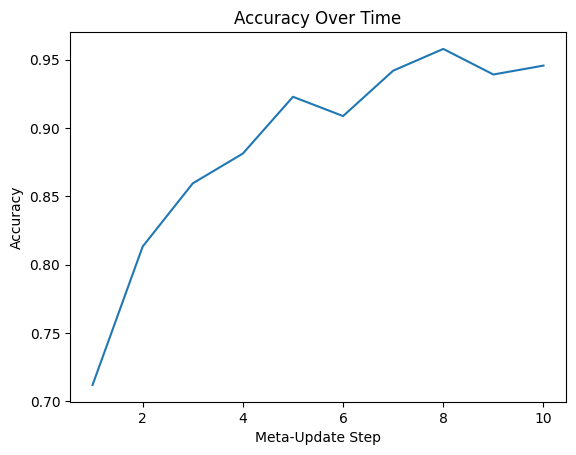

In [46]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))


# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


# Define the MAML model
class MAML(tf.keras.Model):
    def __init__(self, model):
        super(MAML, self).__init__()
        self.model = model

    def train_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            loss = self.compiled_loss(y, y_pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        y_pred = self.model(x)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Define the meta-learning parameters
num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

# Create the MAML model
model = MAML(create_model())
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Initialize variables to store accuracy over time
meta_updates = []
accuracy_over_time = []

# Meta-training loop
for meta_update in range(num_meta_updates):
    # Sample a meta-batch of tasks
    meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

    # Inner loop updates for each task
    for task in meta_batch:
        task_data = (
            x_train[task : task + inner_batch_size],
            y_train[task : task + inner_batch_size],
        )
        for inner_update in range(num_inner_updates):
            model.train_step(task_data)

    # Evaluate on the meta-test set
    _, accuracy = model.evaluate(x_test, y_test)

    # Store the meta-update step and accuracy
    meta_updates.append(meta_update + 1)
    accuracy_over_time.append(accuracy)

# Fine-tuning on a new task
new_task_data = (x_test[:100], y_test[:100])
model.fit(new_task_data[0], new_task_data[1], epochs=1)

# Plot the accuracy over time graph
plt.plot(meta_updates, accuracy_over_time)
plt.xlabel("Meta-Update Step")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Time")
plt.show()

In [47]:
def train_model(model, x_train, y_train):
    for meta_update in range(num_meta_updates):
    # Sample a meta-batch of tasks
        meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

        # Inner loop updates for each task
        for task in meta_batch:
            task_data = (
                x_train[task : task + inner_batch_size],
                y_train[task : task + inner_batch_size],
            )
            for inner_update in range(num_inner_updates):
                model.train_step(task_data)

        # Evaluate on the meta-test set
        _, accuracy = model.evaluate(x_test, y_test)

        # Store the meta-update step and accuracy
        meta_updates.append(meta_update + 1)
        accuracy_over_time.append(accuracy)
        return model , accuracy

In [48]:
cwts = [encrypt_wt(model.get_weights()) for model in models]
for e in tqdm(range(epochs)):
    wts = decrypt_weights(cwts)
    cwts = []
    for wt,model , dataset , i , in zip(wts, models, dataset_parts , clients):
        model.set_weights(wt)
        model, accuracy = train_model(model, dataset[0], dataset[1])
        # history = model.fit(dataset[0], dataset[1], epochs=1,  verbose=1)
        # print(history.history["accuracy"][0], history.history["loss"][0])
        # accuracies[i ].append(history.history["accuracy"][0])
        # losses[i].append(history.history["loss"][0])
        accuracies.append(accuracy)
        print("accuracies" , accuracy)
        wtarray = model.get_weights()
        cwts.append(encrypt_wt(wtarray))

    cwts = aggregate_wt(cwts)

  0%|          | 0/20 [00:00<?, ?it/s]

313/313 [==============================] - 1s 2ms/step - loss: 0.9022 - accuracy: 0.7216
accuracies 0.7215999960899353
313/313 [==============================] - 1s 2ms/step - loss: 0.7524 - accuracy: 0.7622
accuracies 0.7621999979019165
313/313 [==============================] - 1s 2ms/step - loss: 0.7221 - accuracy: 0.8120
accuracies 0.8119999766349792
313/313 [==============================] - 1s 2ms/step - loss: 1.1794 - accuracy: 0.5482
accuracies 0.5482000112533569
313/313 [==============================] - 1s 2ms/step - loss: 0.7535 - accuracy: 0.7584
accuracies 0.758400022983551
313/313 [==============================] - 1s 2ms/step - loss: 0.7131 - accuracy: 0.7598
accuracies 0.7598000168800354
313/313 [==============================] - 1s 2ms/step - loss: 0.7121 - accuracy: 0.7648
accuracies 0.7648000121116638
313/313 [==============================] - 1s 2ms/step - loss: 0.9852 - accuracy: 0.7103
accuracies 0.7103000283241272
313/313 [==============================] - 1s 2ms

  5%|▌         | 1/20 [01:58<37:38, 118.88s/it]

313/313 [==============================] - 1s 2ms/step - loss: 1.2132 - accuracy: 0.5826
accuracies 0.5825999975204468
313/313 [==============================] - 1s 2ms/step - loss: 2.1854 - accuracy: 0.2864
accuracies 0.2863999903202057
313/313 [==============================] - 1s 2ms/step - loss: 1.0245 - accuracy: 0.6561
accuracies 0.6560999751091003
313/313 [==============================] - 1s 2ms/step - loss: 1.5237 - accuracy: 0.5285
accuracies 0.5285000205039978
313/313 [==============================] - 1s 2ms/step - loss: 1.5951 - accuracy: 0.5103
accuracies 0.5102999806404114
313/313 [==============================] - 1s 2ms/step - loss: 1.4553 - accuracy: 0.5569
accuracies 0.5569000244140625
313/313 [==============================] - 1s 3ms/step - loss: 1.7868 - accuracy: 0.3542
accuracies 0.35420000553131104
313/313 [==============================] - 1s 2ms/step - loss: 1.0430 - accuracy: 0.6110
accuracies 0.6110000014305115
313/313 [==============================] - 1s 2

 10%|█         | 2/20 [03:57<35:32, 118.45s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.7665 - accuracy: 0.7474
accuracies 0.7473999857902527
313/313 [==============================] - 1s 2ms/step - loss: 0.8189 - accuracy: 0.7357
accuracies 0.7357000112533569
313/313 [==============================] - 1s 2ms/step - loss: 1.0513 - accuracy: 0.6699
accuracies 0.6699000000953674
313/313 [==============================] - 1s 2ms/step - loss: 0.8796 - accuracy: 0.7148
accuracies 0.7148000001907349
313/313 [==============================] - 1s 2ms/step - loss: 1.3964 - accuracy: 0.6385
accuracies 0.6384999752044678
313/313 [==============================] - 1s 2ms/step - loss: 0.9269 - accuracy: 0.7083
accuracies 0.708299994468689
313/313 [==============================] - 1s 2ms/step - loss: 0.9666 - accuracy: 0.6915
accuracies 0.6915000081062317
313/313 [==============================] - 1s 3ms/step - loss: 0.9603 - accuracy: 0.6999
accuracies 0.6998999714851379
313/313 [==============================] - 1s 4ms

 15%|█▌        | 3/20 [05:53<33:16, 117.45s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.6688 - accuracy: 0.7838
accuracies 0.7838000059127808
313/313 [==============================] - 1s 2ms/step - loss: 0.8659 - accuracy: 0.7450
accuracies 0.7450000047683716
313/313 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.7725
accuracies 0.7724999785423279
313/313 [==============================] - 1s 2ms/step - loss: 0.6634 - accuracy: 0.7974
accuracies 0.7973999977111816
313/313 [==============================] - 1s 2ms/step - loss: 0.5177 - accuracy: 0.8402
accuracies 0.8402000069618225
313/313 [==============================] - 1s 2ms/step - loss: 0.6286 - accuracy: 0.8137
accuracies 0.8137000203132629
313/313 [==============================] - 1s 2ms/step - loss: 0.6468 - accuracy: 0.7836
accuracies 0.7835999727249146
313/313 [==============================] - 1s 2ms/step - loss: 0.5662 - accuracy: 0.8055
accuracies 0.8054999709129333
313/313 [==============================] - 1s 2m

 20%|██        | 4/20 [07:44<30:41, 115.12s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.5531 - accuracy: 0.8300
accuracies 0.8299999833106995
313/313 [==============================] - 1s 2ms/step - loss: 0.3864 - accuracy: 0.8798
accuracies 0.879800021648407
313/313 [==============================] - 1s 2ms/step - loss: 0.5111 - accuracy: 0.8373
accuracies 0.8373000025749207
313/313 [==============================] - 1s 2ms/step - loss: 0.6008 - accuracy: 0.8233
accuracies 0.8233000040054321
313/313 [==============================] - 1s 2ms/step - loss: 0.5790 - accuracy: 0.8226
accuracies 0.8226000070571899
313/313 [==============================] - 1s 2ms/step - loss: 0.5509 - accuracy: 0.8081
accuracies 0.8080999851226807
313/313 [==============================] - 1s 2ms/step - loss: 0.4915 - accuracy: 0.8477
accuracies 0.8476999998092651
313/313 [==============================] - 1s 2ms/step - loss: 0.4818 - accuracy: 0.8486
accuracies 0.8485999703407288
313/313 [==============================] - 1s 2ms

 25%|██▌       | 5/20 [09:37<28:32, 114.16s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.6851 - accuracy: 0.8124
accuracies 0.8123999834060669
313/313 [==============================] - 1s 2ms/step - loss: 0.3768 - accuracy: 0.8876
accuracies 0.8876000046730042
313/313 [==============================] - 1s 2ms/step - loss: 0.4348 - accuracy: 0.8540
accuracies 0.8539999723434448
313/313 [==============================] - 1s 2ms/step - loss: 0.3370 - accuracy: 0.8950
accuracies 0.8949999809265137
313/313 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.8518
accuracies 0.8518000245094299
313/313 [==============================] - 1s 2ms/step - loss: 0.5832 - accuracy: 0.8264
accuracies 0.8263999819755554
313/313 [==============================] - 1s 2ms/step - loss: 0.3866 - accuracy: 0.8767
accuracies 0.8766999840736389
313/313 [==============================] - 1s 2ms/step - loss: 0.4046 - accuracy: 0.8867
accuracies 0.8866999745368958
313/313 [==============================] - 1s 2m

 30%|███       | 6/20 [11:28<26:25, 113.22s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.4849 - accuracy: 0.8588
accuracies 0.8587999939918518
313/313 [==============================] - 1s 2ms/step - loss: 0.6005 - accuracy: 0.8191
accuracies 0.819100022315979
313/313 [==============================] - 1s 2ms/step - loss: 0.7090 - accuracy: 0.7985
accuracies 0.7985000014305115
313/313 [==============================] - 1s 3ms/step - loss: 0.6579 - accuracy: 0.8019
accuracies 0.8019000291824341
313/313 [==============================] - 1s 2ms/step - loss: 0.4675 - accuracy: 0.8768
accuracies 0.876800000667572
313/313 [==============================] - 1s 2ms/step - loss: 0.4554 - accuracy: 0.8634
accuracies 0.8633999824523926
313/313 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.8990
accuracies 0.8989999890327454
313/313 [==============================] - 1s 2ms/step - loss: 0.4645 - accuracy: 0.8483
accuracies 0.8482999801635742
313/313 [==============================] - 1s 2ms/

 35%|███▌      | 7/20 [13:29<25:03, 115.63s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.3204 - accuracy: 0.9006
accuracies 0.900600016117096
313/313 [==============================] - 1s 2ms/step - loss: 0.5241 - accuracy: 0.8659
accuracies 0.8658999800682068
313/313 [==============================] - 1s 3ms/step - loss: 0.4231 - accuracy: 0.8632
accuracies 0.8632000088691711
313/313 [==============================] - 1s 2ms/step - loss: 0.3551 - accuracy: 0.8958
accuracies 0.895799994468689
313/313 [==============================] - 1s 3ms/step - loss: 0.3200 - accuracy: 0.8910
accuracies 0.890999972820282
313/313 [==============================] - 1s 2ms/step - loss: 0.4965 - accuracy: 0.8547
accuracies 0.8547000288963318
313/313 [==============================] - 1s 2ms/step - loss: 0.3023 - accuracy: 0.9068
accuracies 0.9067999720573425
313/313 [==============================] - 1s 2ms/step - loss: 0.5155 - accuracy: 0.8490
accuracies 0.8489999771118164
313/313 [==============================] - 1s 2ms/s

 40%|████      | 8/20 [15:26<23:12, 116.07s/it]

313/313 [==============================] - 1s 2ms/step - loss: 0.4837 - accuracy: 0.8680
accuracies 0.8679999709129333


 40%|████      | 8/20 [15:41<23:32, 117.69s/it]


KeyboardInterrupt: 

In [ ]:
accuracies


[[0.37166666984558105,
  0.4091666638851166,
  0.5533333420753479,
  0.6979166865348816,
  0.7749999761581421,
  0.8054166436195374,
  0.8266666531562805,
  0.8441666960716248,
  0.8525000214576721,
  0.8616666793823242,
  0.8662499785423279,
  0.8725000023841858,
  0.8774999976158142,
  0.878333330154419,
  0.8833333253860474,
  0.8870833516120911,
  0.887499988079071,
  0.8854166865348816,
  0.8929166793823242,
  0.8958333134651184],
 [0.3270833194255829,
  0.39250001311302185,
  0.5641666650772095,
  0.6916666626930237,
  0.777916669845581,
  0.8100000023841858,
  0.8324999809265137,
  0.8550000190734863,
  0.8604166507720947,
  0.8637499809265137,
  0.8725000023841858,
  0.8820833563804626,
  0.8829166889190674,
  0.8879166841506958,
  0.8895833492279053,
  0.8912500143051147,
  0.8954166769981384,
  0.8999999761581421,
  0.8995833396911621,
  0.8983333110809326],
 [0.32124999165534973,
  0.4033333361148834,
  0.559166669845581,
  0.706250011920929,
  0.7724999785423279,
  0.814166

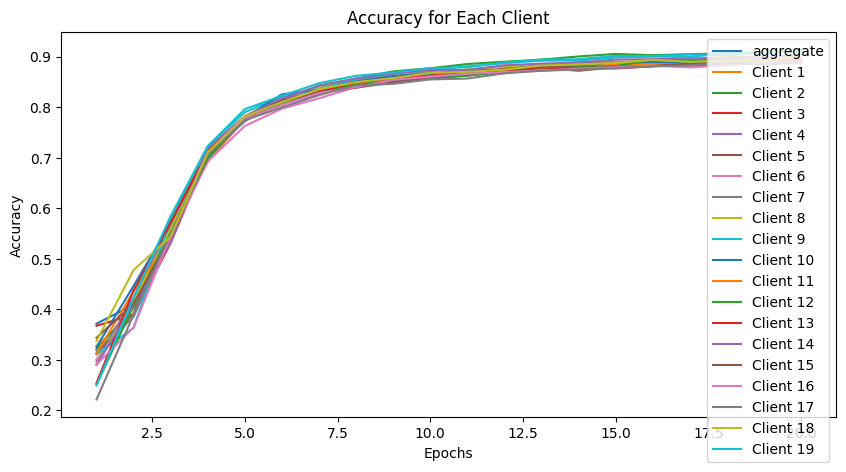

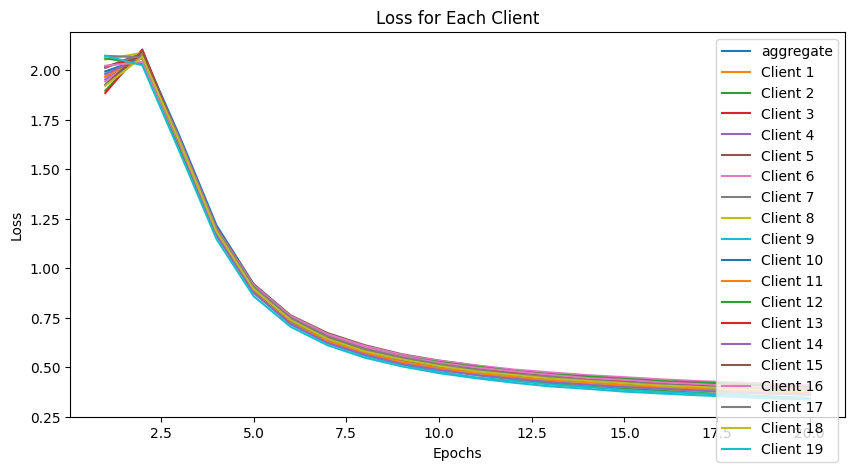

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(
        epochs_range,
        accuracies[i],
        label=f"Client {client}" if client != 0 else "aggregate",
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, losses[i], label=f"Client {client}" if client != 0 else "aggregate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss for Each Client")
plt.show()

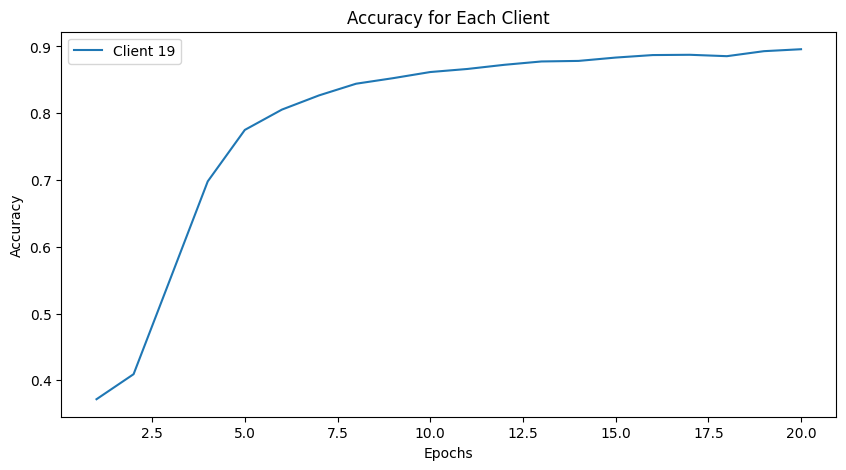

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
# for i, client in enumerate(clients):
plt.plot(epochs_range, accuracies[0], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

1/1 [==============================] - 0s 63ms/step


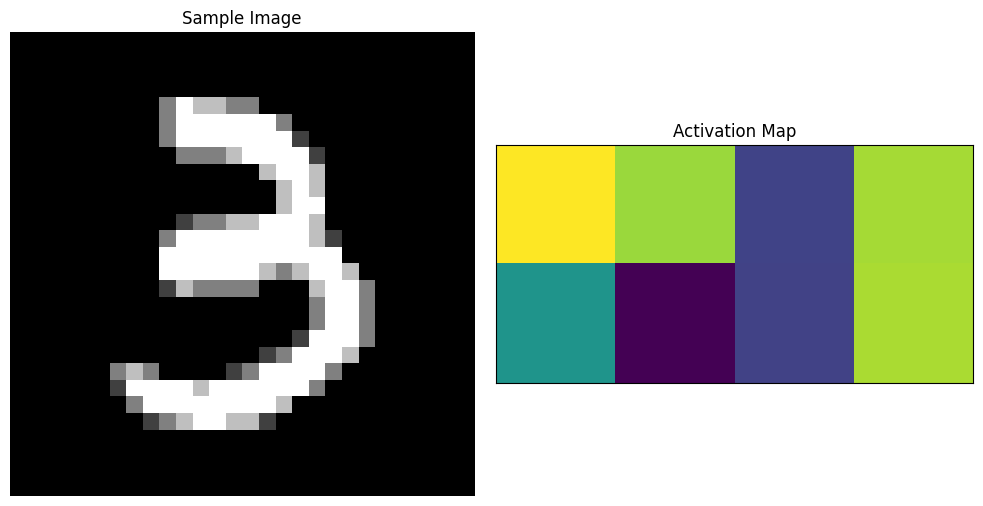

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

model = models[0]
# Assuming you have a trained model named 'model'
# and input data 'X_test' and corresponding labels 'y_test'

# Select a sample image from the test set
# Select a sample image from the test set
sample_image = X_test[1]  # Adjust the index as needed
sample_label = y_test[1]

# Preprocess the sample image
sample_image = sample_image[np.newaxis, ...]  # Add batch dimension

# Initialize the model
# model = model_init()

# Create a model that outputs the activations of the first dense layer
layer_name = "dense_40"  # Name of the first dense layer in your model
activation_model = Model(
    inputs=model.inputs, outputs=model.get_layer(layer_name).output
)

# Get the activations of the first dense layer
activations = activation_model.predict(sample_image)

# Plot the sample image and the activation map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(sample_image[0], cmap="gray")  # Assuming grayscale image
ax1.set_title("Sample Image")
ax1.axis("off")

ax2.imshow(activations[0].reshape(2, 4), cmap="viridis", interpolation="nearest")
ax2.set_title("Activation Map")
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()